In [62]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

In [63]:
# Part a

def load_graph(edge_path, name1_path, name2_path=None, largest_cc=True):
    G = nx.read_edgelist(edge_path, nodetype=int, data=False)
    df1 = pd.read_csv(name1_path, names=['id', 'name'], header=None, skiprows=[
                      0], delim_whitespace=True)
    if name2_path is not None:
        df2 = pd.read_csv(name2_path, names=[
                          'name', 'title'], header=None, skiprows=[0])
        df1 = pd.merge(df1, df2, on='name', how='inner')
        df1.rename(columns={'name': 'code', 'title': 'name'}, inplace=True)
    names = {df1.iloc[i]['id']: df1.iloc[i]['name'] for i in range(len(df1))}
    nx.set_node_attributes(G, names, 'name')
    if largest_cc:
        G = G.subgraph(max(nx.connected_components(G), key=len))
    return G


TITLE = "Airports Graph"
G = load_graph('../datasets/airports.edges',
               '../datasets/airports.codes', '../datasets/name_of_airports.csv')
A = nx.to_numpy_matrix(G, dtype=int)  # Adjacency matrix

# Calculate the degree matrix
D = np.zeros(A.shape, dtype=int)
for i in range(D.shape[0]):
    D[i, i] = np.sum(A[i])

# Calculate the laplacian matrix
L = D - A

print('Adjacency Matrix:\n', A, '\n', sep='')
print('Degree Matrix:\n', D, '\n', sep='')
print('Laplacian Matrix:\n', L, sep='')


Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Degree Matrix:
[[ 2  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]

Laplacian Matrix:
[[ 2 -1 -1 ...  0  0  0]
 [-1 40 -1 ...  0  0  0]
 [-1 -1  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]


In [64]:
# Part b

# Find eigenvalues and eigenvectors
lam, X = np.linalg.eig(L)

# Cast to real values if the imaginary parts are in floating precision to 0
lam = np.real_if_close(lam)
X = np.real_if_close(X, tol=1e20)

# Round values that are at the floating point precision to exactly 0
# First eigenvalue must be 0
lam[np.abs(lam) < 720 * np.finfo(lam.dtype).eps] = 0

# Sort by eigenvalues
i = np.argsort(lam)
lam = lam[i]
X = X[:, i]

# Values of the first eigenvector must be equal
x_med = np.median(np.array(X[:, 0]))
x_max = np.max(np.array(X[:, 0]))
x_min = np.min(np.array(X[:, 0]))
x_eps = max(abs(x_max - x_med), abs(x_min - x_med))
for j in range(X.shape[1]):
    med = np.median(np.array(X[:, j]))
    for i in range(X.shape[0]):
        if np.abs(X[i, j] - med) <= x_eps:
            X[i, j] = med


print('Smallest Eigenvalue:', lam[0])
print('Corresponding Eigenvector:\n', X[:, 0], '\n', sep='')

print('Second Smallest Eigenvalue:', lam[1])
print('Corresponding Eigenvector:\n', X[:, 1], sep='')


Smallest Eigenvalue: 0.0
Corresponding Eigenvector:
[[0.02522166]
 [0.02522166]
 [0.02522166]
 ...
 [0.02522166]
 [0.02522166]
 [0.02522166]]

Second Smallest Eigenvalue: 0.21795319159317073
Corresponding Eigenvector:
[[-0.06043121]
 [-0.05436919]
 [-0.05332205]
 ...
 [ 0.01377518]
 [ 0.01483884]
 [ 0.02437507]]


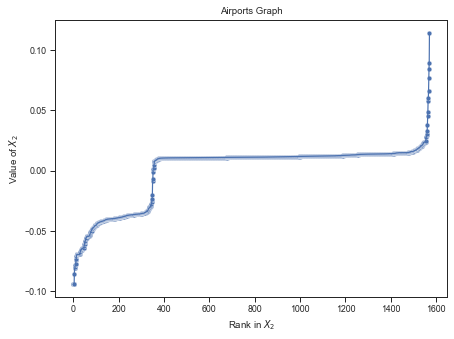

In [65]:
x2_val = np.sort(np.array(X[:, 1]).flatten())
x2_rank = list(range(len(x2_val)))

fig, ax = plt.subplots()
ax.set(
    title=TITLE,
    xlabel=r"Rank in $X_2$",
    ylabel=r"Value of $X_2$",
)
sns.lineplot(x=x2_rank, y=x2_val, ax=ax)
sns.scatterplot(x=x2_rank, y=x2_val, ax=ax)
fig.savefig('x2.png')
plt.show()

In [66]:
# Part c

def modularity(G, S):
    m = sum(dict(G.degree).values()) / 2

    def f(s):
        # Number of intra-partition edges
        E_s = sum(1 for u, v in G.edges(s) if v in s)

        # Sum of degrees of the nodes in the partition
        K_s = sum(G.degree[u] for u in s)

        return E_s / m - (K_s / (2 * m)) ** 2

    Q = sum(map(f, S))
    return Q


def min_cut(G, S):
    m = sum(dict(G.degree).values()) / 2

    def f(s):
        # Number of inter-partition edges
        E_s = sum(1 for u, v in G.edges(s) if v not in s)
        return E_s

    MC = sum(map(f, S)) / (2*m)
    return MC


Best K for Modularity: 9 , Q: 0.20302801991656394
Best K for Min-Cut: 2 , MC: 0.005460671546415708


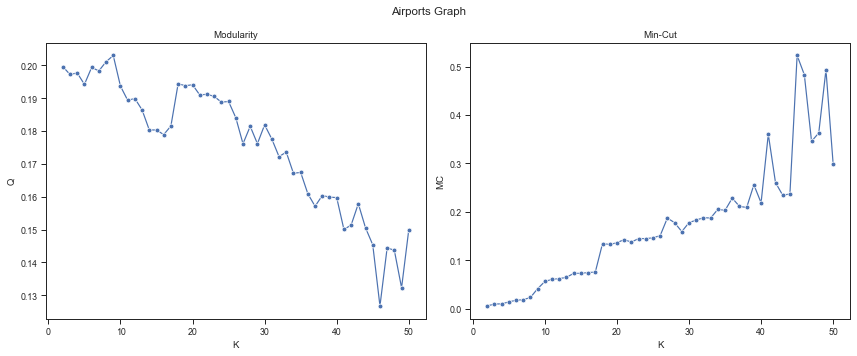

In [67]:
from sklearn.cluster import KMeans

K = list(range(2, 51))
Q = []
MC = []

for k in K:
    mdl = KMeans(n_clusters=k, random_state=3)
    pred = mdl.fit_predict(np.array(X[:, 1]))

    clusters = {}
    nodelist = list(G)
    for i, label in enumerate(pred):
        clusters.setdefault(label, set()).add(nodelist[i])
    clusters = list(clusters.values())
    Q.append(modularity(G, clusters))
    MC.append(min_cut(G, clusters))

print("Best K for Modularity:", K[np.argmax(Q)], ", Q:", max(Q))
print("Best K for Min-Cut:", K[np.argmin(MC)], ", MC:", min(MC))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(TITLE)
ax[0].set(title="Modularity", xlabel="K", ylabel="Q")
ax[1].set(title="Min-Cut", xlabel="K", ylabel="MC")
sns.lineplot(x=K, y=Q, ax=ax[0], marker='o')
sns.lineplot(x=K, y=MC, ax=ax[1], marker='o')
fig.savefig('modularity.png')
plt.show()
